In [1]:
# Import libraries
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import (
    roc_auc_score,
    accuracy_score,
    classification_report,
    ConfusionMatrixDisplay
)
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    StandardScaler,
    OneHotEncoder,
    TargetEncoder,
)
from sklearn.impute import SimpleImputer #,KNNImputer
from sklearn.compose import (
    ColumnTransformer, 
    make_column_selector
)
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE, RFECV
# Models
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
# Explanation and calibration
from sklearn.inspection import (
    PartialDependenceDisplay,
    DecisionBoundaryDisplay,
    permutation_importance
)
from sklearn.calibration import (
    CalibrationDisplay,
    CalibratedClassifierCV
)
from skopt import BayesSearchCV

In [2]:
import sklearn
sklearn.__version__

'1.3.2'

# Modelling

- [x] Define the task (type of problem, set target if at all, choose initial features)
- [x] Check (again) the target (class imbalances)
- [x] Set main metrics, validation strategy
- [x] Train-Test split
- [x] Baseline model
- [ ] Feature engineering pipeline
- [ ] Training, hyperparemeters tuning
- [ ] Features selection
- [ ] Calibration
- [ ] Evaluation
- [ ] Explaination

In [3]:
# Load data.
elec_df = pd.read_parquet("../data/processed/processed_training_full.parquet")
elec_df.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85529 entries, 0 to 85528
Columns: 84 entries, COD_INSEE to Q12_new
dtypes: Float64(4), Int64(41), float64(1), int32(1), int64(2), object(35)
memory usage: 58.2+ MB


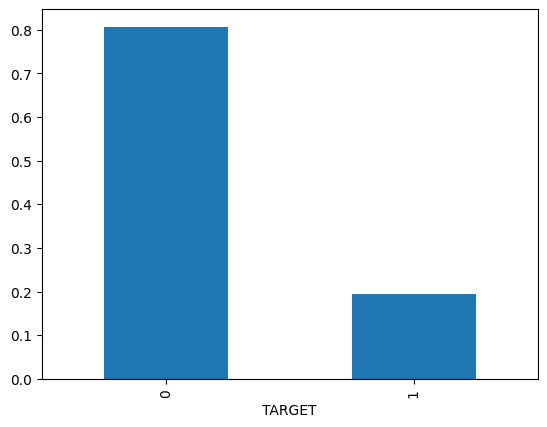

In [4]:
elec_df["TARGET"].value_counts(normalize=True).plot(kind="bar");

In [5]:
elec_df.columns.sort_values()

Index(['C10', 'C11', 'C12', 'C13', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19',
       'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'COD_INSEE', 'COD_IRIS', 'Q1',
       'Q10', 'Q11', 'Q11_new', 'Q12', 'Q12_new', 'Q13', 'Q14', 'Q16', 'Q19',
       'Q2', 'Q20', 'Q21', 'Q22', 'Q24', 'Q25', 'Q26', 'Q27', 'Q28', 'Q3',
       'Q30', 'Q31', 'Q32', 'Q33', 'Q34', 'Q35', 'Q36', 'Q4', 'Q41', 'Q42',
       'Q43', 'Q44', 'Q45', 'Q46', 'Q47', 'Q48', 'Q49', 'Q5', 'Q53', 'Q54',
       'Q55', 'Q57', 'Q58', 'Q59', 'Q61', 'Q62', 'Q63', 'Q64', 'Q67', 'Q68',
       'Q69', 'Q70', 'Q71', 'Q72', 'Q8', 'Q9', 'Q_n_equips_53_75', 'S1', 'S10',
       'S11', 'S12', 'S2', 'S8', 'S9', 'S_n_visits_3_7', 'TARGET'],
      dtype='object')

### Train-Test split, metrics and validation strategy

In [6]:
# Target definition, Features initial choice.
target = "TARGET"
features = [
    'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C10', 'C11', 'C12', 'C13', 'C14', 
    'C15', 'C16', 'C17', 'C18', 'C19',
    # -------------------------------------------------------------------
    'Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q8', 'Q9', 'Q10', 'Q11_new', 'Q12_new', 'Q13', 
    'Q14', 'Q16', 'Q19', 'Q20', 'Q21', 'Q22', 'Q24', 'Q25', 'Q26', 'Q27',
    'Q28', 'Q30', 'Q31', 'Q32', 'Q33', 'Q34', 'Q35', 'Q36', 'Q41', 'Q42',
    'Q43', 'Q44', 'Q45', 'Q46', 'Q47', 'Q48', 'Q49', 'Q53', 'Q54', 'Q55',
    'Q57', 'Q58', 'Q59', 'Q61', 'Q62', 'Q63', 'Q64', 'Q67', 'Q68', 'Q69',
    'Q70', 'Q71', 'Q72', 'Q_n_equips_53_75',
    # -------------------------------------------------------------------
    'S1', 'S2', 'S8', 'S9', 'S10', 'S11', 'S12', 'S_n_visits_3_7',
    # -------------------------------------------------------------------
    'COD_IRIS'
]
high_cardinalty_features = ["COD_IRIS"] 

In [7]:
elec_df["COD_IRIS"] = elec_df["COD_IRIS"].fillna(-99).astype(int)

In [8]:
# Target and Features.
y = elec_df[target]
X = elec_df.drop(columns=target)[features]

# Train-Test split.
random_state = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=random_state)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (68423, 80)
y_train shape: (68423,)
X_test shape: (17106, 80)
y_test shape: (17106,)


In [9]:
# Metrics and validation strategy.
scoring = "accuracy" #"roc_auc"
cv = StratifiedKFold(5)

In [48]:
def print_score_report(clf, return_ypreds=False):
    print("----------- TRAIN -----------")
    y_pred_train = clf.predict(X_train)
    print("Train ROC AUC", roc_auc_score(y_train, y_pred_train).round(2))
    print("\nTrain Classification Report\n", classification_report(y_train, y_pred_train, zero_division=0.0))

    print("----------- TEST -----------")
    y_pred_test = clf.predict(X_test)
    print("Test ROC AUC", roc_auc_score(y_test, y_pred_test).round(2))
    print("\nTest Classification Report\n", classification_report(y_test, y_pred_test, zero_division=0.0))

    if return_ypreds:
        return (y_pred_train, y_pred_test)
    return None

### Baseline Model

In [49]:
# Baseline Model.
dummy_clf = DummyClassifier(strategy="most_frequent", random_state=random_state)
dummy_clf.fit(X_train, y_train)
y_pred = np.int64(dummy_clf.predict(X_train))
print("-------- MOST FREQUENT ----------")
print(print_score_report(dummy_clf))

print("-------- STRATIFIED -------------")
dummy_strat_clf = DummyClassifier(strategy="stratified", random_state=random_state)
dummy_strat_clf.fit(X_train, y_train)
y_pred = np.int64(dummy_strat_clf.predict(X_train))
print("Dummy Classifier ROC-AUC score:", roc_auc_score(y_train, y_pred))
print("Dummy Classifier ROC-AUC score:\n", classification_report(y_train, y_pred, zero_division=0.0))


-------- MOST FREQUENT ----------
----------- TRAIN -----------
Train ROC AUC 0.5

Train Classification Report
               precision    recall  f1-score   support

         0.0       0.81      1.00      0.89     55177
         1.0       0.00      0.00      0.00     13246

    accuracy                           0.81     68423
   macro avg       0.40      0.50      0.45     68423
weighted avg       0.65      0.81      0.72     68423

----------- TEST -----------
Test ROC AUC 0.5

Test Classification Report
               precision    recall  f1-score   support

         0.0       0.81      1.00      0.89     13794
         1.0       0.00      0.00      0.00      3312

    accuracy                           0.81     17106
   macro avg       0.40      0.50      0.45     17106
weighted avg       0.65      0.81      0.72     17106

None
-------- STRATIFIED -------------
Dummy Classifier ROC-AUC score: 0.4957601047485931
Dummy Classifier ROC-AUC score:
               precision    recall  f

### Preprocessing Pipelines

In [12]:
# Preprocessing
## StandardScaler for numerical
## OneHotEncoding for categorical
## TargetEncoder for high-cardinality
## Feature Selection / No Feature Selection

# Model instantiation and hyperparemeter grids.
## Regression Logistic / ELasticsNet

## Random Forest

## AdaBoost

## XGBoost

In [28]:
# Build column transformers
categorical_features = make_column_selector(dtype_include=['object', 'string'])
numerical_features = make_column_selector(dtype_include=['number'])
all_features = make_column_selector(dtype_include=['number', 'object'])
# Create transformers pipeline
preprocessor = ColumnTransformer([
    ("ohe", OneHotEncoder(drop="if_binary", handle_unknown="ignore"), categorical_features),
    # ("imputer_cat", SimpleImputer(strategy="most_frequent"), categorical_features),
    # ("imputer_num", SimpleImputer(strategy="median"), numerical_features),
    ("scaler", StandardScaler(), numerical_features),
    ("targe_tenc", TargetEncoder(), high_cardinalty_features),
    # ("imputer", KNNImputer(weights="distance"), all_features),
    # ("feature_selection", RFECV())
])
cat_preprocessor = ColumnTransformer([
    ("ohe", OneHotEncoder(drop="if_binary", handle_unknown="ignore"), categorical_features),
])

# Model instantiation for Logistic Regression (4 * 5 * 5cv = 100)
Cs = np.logspace(-4, 0, 4) # 3
l1_ratios = [1.0] #[.0, .5, 1.0] # 3
estimator_lr = LogisticRegressionCV(Cs=Cs, cv=cv, scoring=scoring, solver='saga',
                                    penalty="elasticnet", l1_ratios=l1_ratios,
                                    verbose=5, random_state=random_state,
                                    fit_intercept=False)
# Build pipeline for Logistic Regression
logreg_clf = Pipeline([
    ('preprocessor', preprocessor),
    ('imputer', SimpleImputer(strategy="median")),
    ('estimator', estimator_lr),
])

# Hyperparameter grid for Random Forest
rf_params = {
    'estimator__n_estimators': (100, 200),
    # 'estimator__max_depth': (5, 30),
    'estimator__min_samples_leaf': (1, 20),
    'estimator__ccp_alpha': (0., 1e-1)
}
# Build pipeline for Random Forest
rf_clf = Pipeline([
    ('preprocessor', cat_preprocessor),
    ("feature_selection", RFE(RandomForestClassifier(n_estimators=20), n_features_to_select=0.2, step=0.4)),
    ('estimator', RandomForestClassifier(class_weight="balanced_subsample"))
])
# Bayesian Search for Random Forest
rf_search = BayesSearchCV(rf_clf, rf_params, n_iter=10, random_state=42, n_jobs=-1, cv=cv)

### Training, cross-validation, hyperparameters tuning 

In [14]:
# Logistic Regression (or ElasticNetCV)
logreg_clf.fit(X_train, y_train)

convergence after 96 epochs took 15 seconds
max_iter reached after 15 seconds


c:\Users\Yedidia AGNIMO\Documents\YouTrend\YouTrend\venv_youtrend\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


max_iter reached after 16 seconds


c:\Users\Yedidia AGNIMO\Documents\YouTrend\YouTrend\venv_youtrend\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


max_iter reached after 16 seconds


c:\Users\Yedidia AGNIMO\Documents\YouTrend\YouTrend\venv_youtrend\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


convergence after 95 epochs took 14 seconds
max_iter reached after 15 seconds


c:\Users\Yedidia AGNIMO\Documents\YouTrend\YouTrend\venv_youtrend\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


max_iter reached after 17 seconds


c:\Users\Yedidia AGNIMO\Documents\YouTrend\YouTrend\venv_youtrend\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


max_iter reached after 15 seconds


c:\Users\Yedidia AGNIMO\Documents\YouTrend\YouTrend\venv_youtrend\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


convergence after 95 epochs took 14 seconds
max_iter reached after 15 seconds


c:\Users\Yedidia AGNIMO\Documents\YouTrend\YouTrend\venv_youtrend\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


max_iter reached after 16 seconds


c:\Users\Yedidia AGNIMO\Documents\YouTrend\YouTrend\venv_youtrend\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


max_iter reached after 16 seconds


c:\Users\Yedidia AGNIMO\Documents\YouTrend\YouTrend\venv_youtrend\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


convergence after 99 epochs took 14 seconds
max_iter reached after 15 seconds


c:\Users\Yedidia AGNIMO\Documents\YouTrend\YouTrend\venv_youtrend\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


max_iter reached after 16 seconds


c:\Users\Yedidia AGNIMO\Documents\YouTrend\YouTrend\venv_youtrend\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


max_iter reached after 20 seconds


c:\Users\Yedidia AGNIMO\Documents\YouTrend\YouTrend\venv_youtrend\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


convergence after 97 epochs took 19 seconds
max_iter reached after 20 seconds


c:\Users\Yedidia AGNIMO\Documents\YouTrend\YouTrend\venv_youtrend\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


max_iter reached after 16 seconds


c:\Users\Yedidia AGNIMO\Documents\YouTrend\YouTrend\venv_youtrend\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


max_iter reached after 17 seconds


c:\Users\Yedidia AGNIMO\Documents\YouTrend\YouTrend\venv_youtrend\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


max_iter reached after 20 seconds


c:\Users\Yedidia AGNIMO\Documents\YouTrend\YouTrend\venv_youtrend\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('ohe',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000002B39888BA90>),
                                                 ('scaler', StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000002B3FFE07B80>),
                                                 ('targe_tenc', TargetEnco...
                                                  ['COD_IRIS'])])),
                ('imputer', SimpleImputer(strategy='median')),
                ('estimator',
                 LogisticRegressionCV(Cs=array([1.00000000e-04, 2.15443469e-03, 4.64158883e-02, 1.00000000e+00]),
                                      cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                                      fit_intercept=False, l1_ratios=[1.0],
                                      penalty='elasticnet', random_state=42,
                                      scoring='accuracy', solver='saga',
                                      verbose=5))])

In [51]:
# with open('../model/logreg_clf_2.pickle', 'wb') as fp:
# 	pickle.dump(logreg_clf, fp)

# with open('../model/logreg_clf.pickle', 'rb') as fp:
# 	logreg_clf = pickle.load(fp)

with open('../model/logreg_clf_2.pickle', 'rb') as fp:
	logreg_clf = pickle.load(fp)


In [52]:
# Inspect result : coef_, C_, l1_ratio_, score_, coefs_paths_
print("Optimal C:", logreg_clf.named_steps["estimator"].C_[0])
print("Optimal l1_ratio:", logreg_clf.named_steps["estimator"].l1_ratio_[0])
print("Best scores:", logreg_clf.named_steps["estimator"].scores_[1].mean().round(2))
print_score_report(logreg_clf)

Optimal C: 1.0
Optimal l1_ratio: 1.0
Best scores: 0.81
----------- TRAIN -----------
Train ROC AUC 0.53

Train Classification Report
               precision    recall  f1-score   support

         0.0       0.82      0.99      0.89     55177
         1.0       0.58      0.07      0.12     13246

    accuracy                           0.81     68423
   macro avg       0.70      0.53      0.51     68423
weighted avg       0.77      0.81      0.74     68423

----------- TEST -----------
Test ROC AUC 0.52

Test Classification Report
               precision    recall  f1-score   support

         0.0       0.81      0.99      0.89     13794
         1.0       0.49      0.05      0.10      3312

    accuracy                           0.81     17106
   macro avg       0.65      0.52      0.49     17106
weighted avg       0.75      0.81      0.74     17106



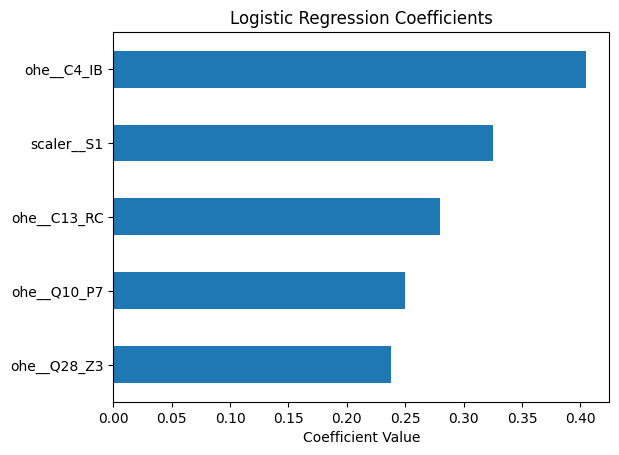

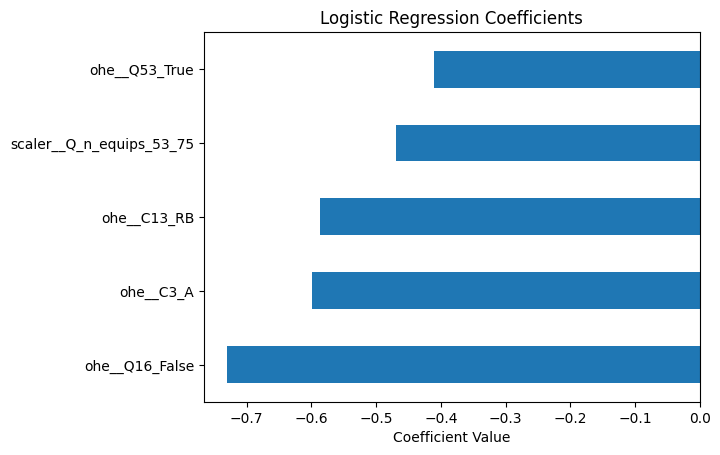

In [27]:
# Coefficient estimates.
coefs = logreg_clf.named_steps["estimator"].coef_
coefs_series = pd.Series(coefs.ravel(), index=logreg_clf[:-1].get_feature_names_out())
coefs_series.sort_values().tail(5).plot(kind="barh", xlabel='Coefficient Value', title='Logistic Regression Coefficients')
plt.show()
coefs_series.sort_values().head(5).plot(kind="barh", xlabel='Coefficient Value', title='Logistic Regression Coefficients')
plt.show()

* Accordingly to some literature [Programs for machine learning](https://linkinghub.elsevier.com/retrieve/pii/S0019995862906496) it preferable to let each tree of the forest grow until its leave then prune it. The pruning can be done using Minimum cost complexity algorithm. This algorithm is parametrize by a complexity parameter $\alpha$. This required a prior analysis on one tree to get the effective alphas to test during the tuning.

* Indeed, the cost complexity at a node t of a tree $T$ is $R_{\alpha}(t) = R(t) + \alpha$, where $R(t) is a measure of impurity (misclassification rate often). In general, the  impurity of a node is greater or equal than the sum of impurities of its terminal node. The effective alphas are values such that the equality hold. Then we just have to tune through this parameters space instead of tuning the depth, the number of nodes or the total impurity.

* Here, we just consider a simple "classical" case of hyperparemater search.

In [29]:
# Random Forest
rf_clf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('ohe',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000002B3AE2F1780>)])),
                ('feature_selection',
                 RFE(estimator=RandomForestClassifier(n_estimators=20),
                     n_features_to_select=0.2, step=0.4)),
                ('estimator',
                 RandomForestClassifier(class_weight='balanced_subsample'))])

> :WARNING:
>
> The serialized version of the random forest is too heavy to be uploaded to Github. If you really want to run it :
> 1. Download the repository
> 2. Go to _model_ folder and unzip _rf\_clf.rar_
> 3. Then, run the cells below 

In [34]:
# with open('../model/rf_clf.pickle', 'wb') as fp:
# 	pickle.dump(rf_clf, fp)

### WARNING 
with open('../model/rf_clf.pickle', 'rb') as fp:
	rf_clf = pickle.load(fp)

In [45]:
# Inspect result :
best_rf_clf = rf_clf.named_steps["estimator"] 
print(best_rf_clf.get_params())
print_score_report(rf_clf)

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
----------- TRAIN -----------
Train ROC AUC 0.75

Train Classification Report
               precision    recall  f1-score   support

 No Employed       0.93      0.76      0.83     55177
    Employed       0.43      0.75      0.54     13246

    accuracy                           0.76     68423
   macro avg       0.68      0.75      0.69     68423
weighted avg       0.83      0.76      0.78     68423

----------- TEST -----------
Test ROC AUC 0.53

Test Classification Report
               precision    recall  f1-score   support

 No Employed       0.82      0.71      0.76     13794


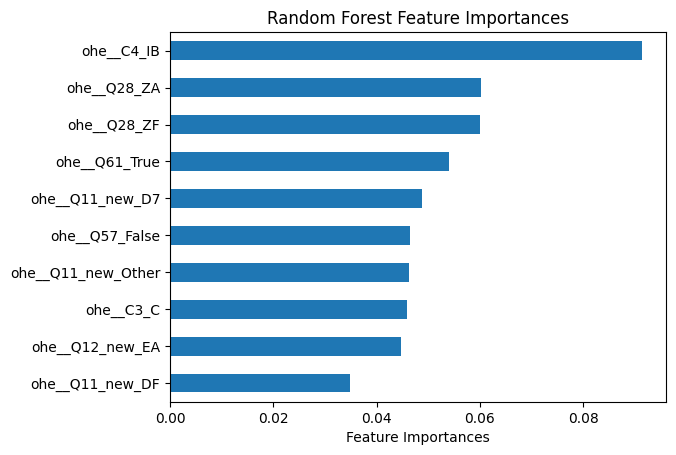

In [63]:
preproc_rf_clf = rf_clf[:-1]
feature_importances = best_rf_clf.feature_importances_
feature_names = preproc_rf_clf.get_feature_names_out()
importances = pd.Series(feature_importances, index=feature_names)
importances.sort_values().tail(10).plot(kind="barh", xlabel='Feature Importances', title='Random Forest Feature Importances')
plt.show()

* Base Model Accuracy (train, test) = (0.81, 0.69) 
* Better performance of Logistic Regression (0.81, 0.81) that generalized very well.
* Poor performance of RF (lower accuracy than dummy classifier).
  * Need more tuning. We just take it as a sample of procedure.
  * PCA could help to reduce dimension first before.

* Whatever the model, the feature _C4_ has the highest importances. It seems people with C4=IB are more the more likely to be make economies.